## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<

In [2]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [3]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [4]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [36]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [35]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [7]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [8]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'



In [9]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving compas-scores-two-years_v1.csv to compas-scores-two-years_v1.csv
User uploaded file "compas-scores-two-years_v1.csv" with length 2416405 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [10]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)

    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    orig_data['age'] = orig_data['age'].astype('int')
    orig_data['two_year_recid'] = orig_data['two_year_recid'].astype('int')
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    orig_data['age'] = orig_data['age'].astype('int')
    orig_data['two_year_recid'] = orig_data['two_year_recid'].astype('int')
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

## Data_Visualization

In [11]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [12]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


In [13]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_dataset.groupby(orig_dataset[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(413, 11) (2396, 11) (762, 11) (2601, 11)


In [14]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_zero_non_priv is maximum


In [15]:
maximum = maximum[0]
print(maximum)

2601


In [16]:
orig_data_zero_priv.shape[0]

762

In [17]:
orig_data_one_non_priv

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,am,two_year_recid
1,34,F,African-American,25 - 45,Low,1,0.0,-1.0,3.0,1,1
2,24,F,African-American,Less than 25,Low,1,4.0,-1.0,4.0,1,1
4,41,F,Caucasian,25 - 45,Medium,1,14.0,-1.0,6.0,0,1
8,23,M,African-American,Less than 25,Medium,1,3.0,0.0,6.0,1,1
12,31,F,African-American,25 - 45,Low,1,7.0,22.0,3.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6150,24,M,African-American,Less than 25,Low,1,2.0,-1.0,3.0,1,1
6154,35,M,African-American,25 - 45,Medium,1,8.0,0.0,7.0,1,1
6160,30,F,African-American,25 - 45,High,1,19.0,0.0,10.0,1,1
6164,21,M,Caucasian,Less than 25,Medium,1,0.0,-1.0,6.0,0,1


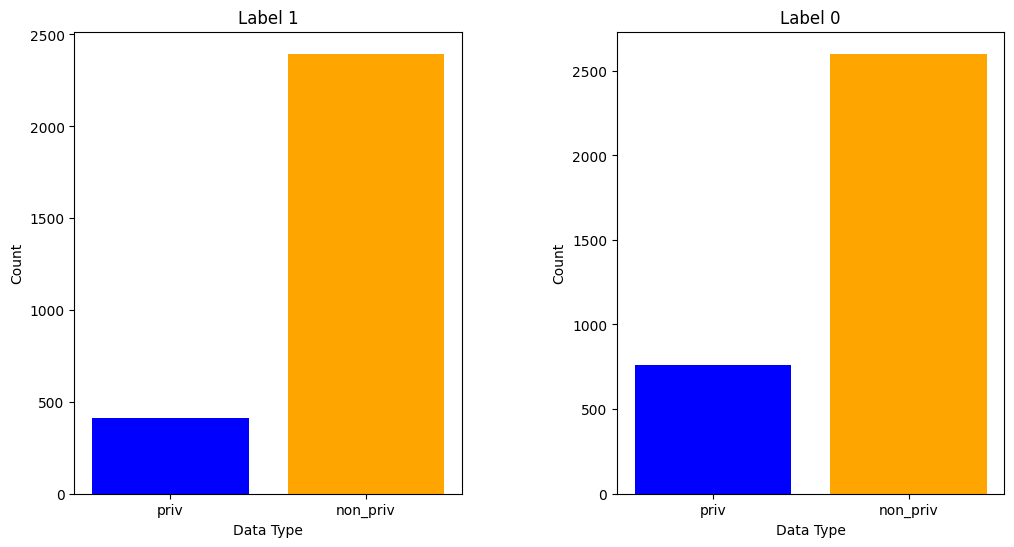

In [18]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [19]:
orig_data

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,am
0,69,F,Other,Greater than 45,Low,1,0.0,-1.0,1.0,0
1,34,F,African-American,25 - 45,Low,1,0.0,-1.0,3.0,1
2,24,F,African-American,Less than 25,Low,1,4.0,-1.0,4.0,1
3,44,M,Other,25 - 45,Low,1,0.0,0.0,1.0,0
4,41,F,Caucasian,25 - 45,Medium,1,14.0,-1.0,6.0,0
...,...,...,...,...,...,...,...,...,...,...
6167,23,F,African-American,Less than 25,Medium,1,0.0,-1.0,7.0,1
6168,23,F,African-American,Less than 25,Low,1,0.0,-1.0,3.0,1
6169,57,F,Other,Greater than 45,Low,1,0.0,-1.0,1.0,0
6170,33,M,African-American,25 - 45,Low,0,3.0,-1.0,2.0,1


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[500 173]
 [220 342]] 
accuracy:  0.6817813765182186 precision:  0.6640776699029126 recall:  0.608540925266904 fpr:  0.25705794947994054 tpr:  0.608540925266904 fn+fp 393
performance for 0 sub-group:
conf matrix:
  [[393 149]
 [165 309]] 
accuracy:  0.6909448818897638 precision:  0.6746724890829694 recall:  0.6518987341772152 fpr:  0.27490774907749077 tpr:  0.6518987341772152 fn+fp 314
performance for 1 sub-group:
conf matrix:
  [[107  24]
 [ 55  33]] 
accuracy:  0.639269406392694 precision:  0.5789473684210527 recall:  0.375 fpr:  0.183206106870229 tpr:  0.375 fn+fp 79
bias metrics:
equal opportunity for tpr: (close to 0) 0.2768987341772152
equal opportunity for fpr: (close to 0) 0.09170164220726176
avarage absolute odds difference: (close to 0) 0.18430018819223848
statistical parity difference: (close to 0)  0.7786407766990291
disparate_impact: (close to 1)  0.013774536821130286
performance for whole d

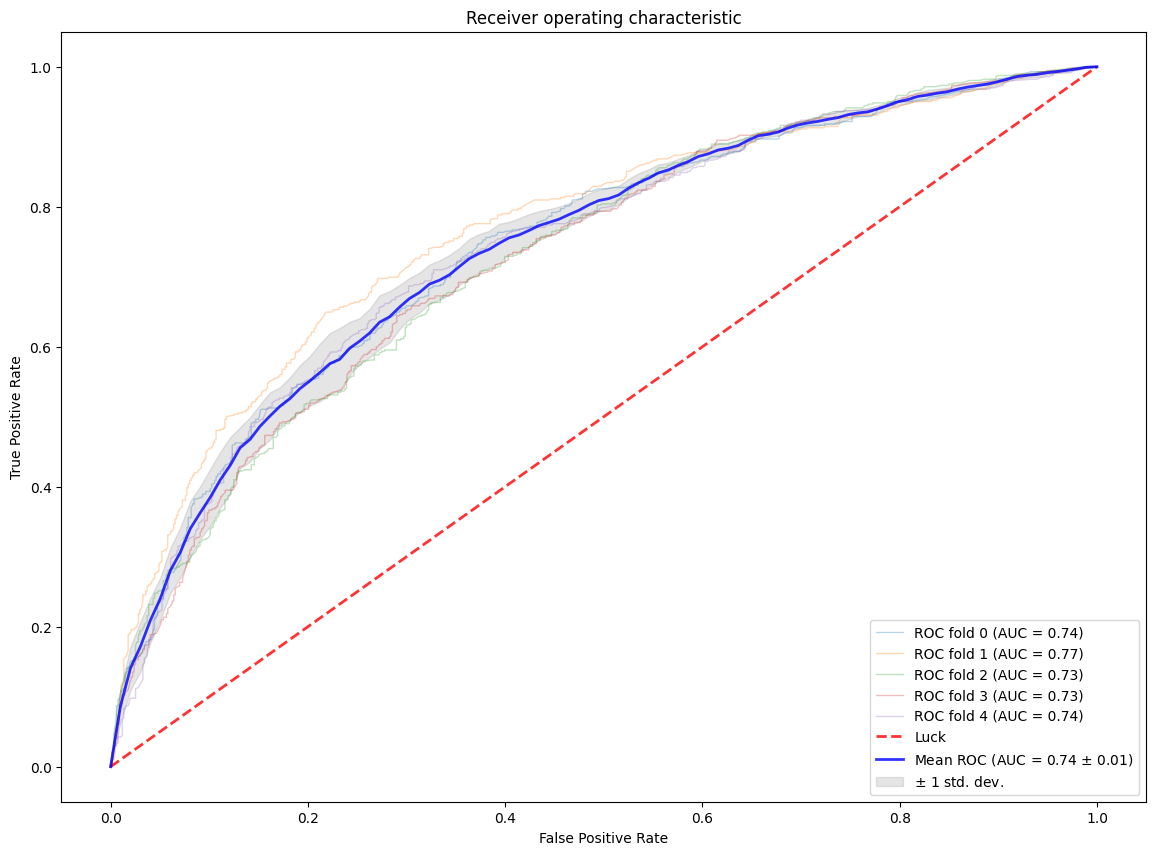

In [20]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [21]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

Accaracy list :  [0.6817813765182186, 0.7157894736842105, 0.6620745542949756, 0.6693679092382496, 0.6904376012965965]
equal opportunity for tpr :  [0.2768987341772152, 0.16279210010553297, 0.16469893742621017, 0.02739757434028023, 0.20061373225930185]
equal opportunity for fpr :  [0.09170164220726176, 0.09581998793111451, 0.11443894389438944, 0.14261398803383538, 0.20303515010509338]
odds difference list :  [0.18430018819223848, 0.12930604401832374, 0.1395689406602998, 0.0850057811870578, 0.2018244411821976]
The mean accuracy is  0.684 ± 0.019
The mean equal opportunity for tpr: (close to 0) 0.166 ± 0.081
The mean equal opportunity for fpr: (close to 0) 0.130 ± 0.041
The mean odds difference: (close to 0) 0.148 ± 0.041
The mean parity difference: (close to 0) 0.763 ± 0.036
The mean disperate impact: (close to 1) 0.016 ± 0.005
1839 0 2188 205


In [22]:
orig_data_zero_priv

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,am,two_year_recid
6,39,M,Caucasian,25 - 45,Low,0,0.0,-1.0,1.0,0,0
9,37,M,Caucasian,25 - 45,Low,0,0.0,0.0,1.0,0,0
20,21,F,Caucasian,Less than 25,Low,0,0.0,-2.0,4.0,0,0
35,21,F,African-American,Less than 25,High,0,2.0,-1.0,8.0,1,0
38,51,F,African-American,Greater than 45,Low,0,7.0,-1.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6138,22,F,Caucasian,Less than 25,Medium,0,1.0,-1.0,7.0,0,0
6139,49,F,Caucasian,Greater than 45,Low,0,3.0,-1.0,2.0,0,0
6140,61,M,Caucasian,Greater than 45,Low,0,1.0,0.0,1.0,0,0
6142,49,F,Caucasian,Greater than 45,Medium,0,2.0,-1.0,6.0,0,0


# CTGAN On Priv Target Group

In [23]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79fea37cb400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py

Epoch 1, Loss G:  1.2034,Loss D: -0.0103
Epoch 2, Loss G:  1.1506,Loss D: -0.0241
Epoch 3, Loss G:  1.1356,Loss D: -0.0292
Epoch 4, Loss G:  1.1506,Loss D:  0.0087
Epoch 5, Loss G:  1.1108,Loss D:  0.0035
Epoch 6, Loss G:  1.0641,Loss D: -0.0162
Epoch 7, Loss G:  1.1114,Loss D: -0.0253
Epoch 8, Loss G:  1.0538,Loss D: -0.0052
Epoch 9, Loss G:  1.0253,Loss D: -0.0804
Epoch 10, Loss G:  1.0227,Loss D: -0.0949
Epoch 11, Loss G:  1.0539,Loss D: -0.0260
Epoch 12, Loss G:  1.0081,Loss D: -0.0768
Epoch 13, Loss G:  1.0131,Loss D: -0.0310
Epoch 14, Loss G:  0.9583,Loss D: -0.1008
Epoch 15, Loss G:  0.8955,Loss D: -0.1672
Epoch 16, Loss G:  0.9197,Loss D: -0.1458
Epoch 17, Loss G:  0.7985,Loss D: -0.0450
Epoch 18, Loss G:  0.8036,Loss D: -0.0795
Epoch 19, Loss G:  0.7274,Loss D: -0.0461
Epoch 20, Loss G:  0.7259,Loss D: -0.0045
Epoch 21, Loss G:  0.7110,Loss D: -0.1555
Epoch 22, Loss G:  0.6137,Loss D: -0.0715
Epoch 23, Loss G:  0.6132,Loss D:  0.0326
Epoch 24, Loss G:  0.4855,Loss D: -0.1086
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.0870,Loss D: -0.0148
Epoch 2, Loss G:  1.0306,Loss D: -0.0452
Epoch 3, Loss G:  0.8779,Loss D: -0.1114
Epoch 4, Loss G:  0.6501,Loss D: -0.1443
Epoch 5, Loss G:  0.4632,Loss D: -0.1870
Epoch 6, Loss G:  0.3596,Loss D: -0.2434
Epoch 7, Loss G:  0.2026,Loss D:  0.1608
Epoch 8, Loss G: -0.0540,Loss D:  0.1322
Epoch 9, Loss G: -0.0440,Loss D:  0.1914
Epoch 10, Loss G:  0.0892,Loss D:  0.0181
Epoch 11, Loss G:  0.3909,Loss D: -0.2095
Epoch 12, Loss G:  0.3695,Loss D: -0.0989
Epoch 13, Loss G:  0.1252,Loss D: -0.0195
Epoch 14, Loss G:  0.0071,Loss D:  0.1873
Epoch 15, Loss G: -0.1680,Loss D:  0.0865
Epoch 16, Loss G: -0.0972,Loss D:  0.1873
Epoch 17, Loss G:  0.0818,Loss D:  0.0425
Epoch 18, Loss G: -0.0969,Loss D:  0.0603
Epoch 19, Loss G: -0.1527,Loss D:  0.1930
Epoch 20, Loss G: -0.3488,Loss D:  0.2423
Epoch 21, Loss G: -0.3005,Loss D: -0.0109
Epoch 22, Loss G: -0.0549,Loss D: -0.1522
Epoch 23, Loss G: -0.0204,Loss D: -0.3278
Epoch 24, Loss G: -0.2647,Loss D: -0.1616
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.3136,Loss D:  0.0126


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


Epoch 2, Loss G:  1.2989,Loss D:  0.0072
Epoch 3, Loss G:  1.2625,Loss D:  0.0152
Epoch 4, Loss G:  1.2822,Loss D: -0.0405
Epoch 5, Loss G:  1.3011,Loss D: -0.0538
Epoch 6, Loss G:  1.2864,Loss D: -0.0370
Epoch 7, Loss G:  1.2845,Loss D: -0.0611
Epoch 8, Loss G:  1.2849,Loss D: -0.0500
Epoch 9, Loss G:  1.2426,Loss D: -0.0479
Epoch 10, Loss G:  1.2857,Loss D: -0.0437
Epoch 11, Loss G:  1.2281,Loss D: -0.0548
Epoch 12, Loss G:  1.2692,Loss D: -0.0860
Epoch 13, Loss G:  1.2653,Loss D: -0.1435
Epoch 14, Loss G:  1.2300,Loss D: -0.1143
Epoch 15, Loss G:  1.2579,Loss D: -0.0970
Epoch 16, Loss G:  1.1996,Loss D: -0.1085
Epoch 17, Loss G:  1.1913,Loss D: -0.1003
Epoch 18, Loss G:  1.1683,Loss D: -0.1552
Epoch 19, Loss G:  1.1480,Loss D: -0.1424
Epoch 20, Loss G:  1.1024,Loss D: -0.1264
Epoch 21, Loss G:  1.1076,Loss D: -0.2163
Epoch 22, Loss G:  1.0883,Loss D: -0.0843
Epoch 23, Loss G:  1.0054,Loss D: -0.1519
Epoch 24, Loss G:  0.9887,Loss D: -0.0541
Epoch 25, Loss G:  0.9601,Loss D: -0.0228


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.0936,Loss D: -0.0245
Epoch 2, Loss G:  0.9989,Loss D: -0.0302
Epoch 3, Loss G:  0.9578,Loss D: -0.0877
Epoch 4, Loss G:  0.9476,Loss D: -0.0578
Epoch 5, Loss G:  0.6996,Loss D: -0.1137
Epoch 6, Loss G:  0.5949,Loss D: -0.0816
Epoch 7, Loss G:  0.4827,Loss D: -0.1593
Epoch 8, Loss G:  0.3382,Loss D: -0.0669
Epoch 9, Loss G:  0.2184,Loss D: -0.1237
Epoch 10, Loss G:  0.1847,Loss D:  0.0232
Epoch 11, Loss G:  0.1119,Loss D:  0.1810
Epoch 12, Loss G:  0.0575,Loss D:  0.2040
Epoch 13, Loss G:  0.2400,Loss D:  0.0340
Epoch 14, Loss G:  0.3612,Loss D: -0.0944
Epoch 15, Loss G:  0.3255,Loss D:  0.0236
Epoch 16, Loss G:  0.3062,Loss D:  0.0430
Epoch 17, Loss G:  0.2993,Loss D: -0.0083
Epoch 18, Loss G:  0.4110,Loss D: -0.0606
Epoch 19, Loss G:  0.4635,Loss D: -0.0825
Epoch 20, Loss G:  0.4203,Loss D: -0.1572
Epoch 21, Loss G:  0.2399,Loss D: -0.2043
Epoch 22, Loss G:  0.2272,Loss D:  0.1109
Epoch 23, Loss G:  0.0988,Loss D:  0.0379
Epoch 24, Loss G:  0.0419,Loss D:  0.2661
E

In [24]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [25]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [26]:
Upsampled_Dataset

,index,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,am,two_year_recid
0,0,69,F,Other,Greater than 45,Low,1,0.000000,-1.000000,1.000000,0,0
1,1,34,F,African-American,25 - 45,Low,1,0.000000,-1.000000,3.000000,1,1
2,2,24,F,African-American,Less than 25,Low,1,4.000000,-1.000000,4.000000,1,1
3,3,44,M,Other,25 - 45,Low,1,0.000000,0.000000,1.000000,0,0
4,4,41,F,Caucasian,25 - 45,Medium,1,14.000000,-1.000000,6.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10399,10399,25,M,Caucasian,25 - 45,Medium,1,-0.905997,-19.455413,8.228145,1,1
10400,10400,19,F,African-American,Greater than 45,High,1,-0.010228,-0.099650,9.648902,1,1
10401,10401,59,M,Caucasian,25 - 45,Low,1,-0.780279,-0.899303,1.572540,1,1
10402,10402,16,F,Other,Less than 25,Low,1,7.307111,-0.737501,1.782661,1,1


In [27]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]
Upsampled_df_features
Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,am
0,69,0.499748,0.361516,0.320186,0.314528,1,0.000000,-1.000000,1.000000,0
1,34,0.499748,0.523150,0.464609,0.314528,1,0.000000,-1.000000,3.000000,1
2,24,0.499748,0.523150,0.559762,0.314528,1,4.000000,-1.000000,4.000000,1
3,44,0.374659,0.361516,0.464609,0.314528,1,0.000000,0.000000,1.000000,0
4,41,0.499748,0.390870,0.464609,0.551338,1,14.000000,-1.000000,6.000000,0
...,...,...,...,...,...,...,...,...,...,...
10399,25,0.374659,0.390870,0.464609,0.551338,1,-0.905997,-19.455413,8.228145,1
10400,19,0.499748,0.523150,0.320186,0.740385,1,-0.010228,-0.099650,9.648902,1
10401,59,0.374659,0.390870,0.464609,0.314528,1,-0.780279,-0.899303,1.572540,1
10402,16,0.499748,0.361516,0.559762,0.314528,1,7.307111,-0.737501,1.782661,1


In [28]:
y_upsampled = Upsampled_Dataset[TARGET_COL]
y_upsampled

0        0
1        1
2        1
3        0
4        1
        ..
10399    1
10400    1
10401    1
10402    1
10403    1
Name: two_year_recid, Length: 10404, dtype: int64

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[793 248]
 [322 718]] 
accuracy:  0.7260932244113407 precision:  0.7432712215320911 recall:  0.6903846153846154 fpr:  0.23823246878001922 tpr:  0.6903846153846154 fn+fp 570
performance for 0 sub-group:
conf matrix:
  [[422  88]
 [139 385]] 
accuracy:  0.7804642166344294 precision:  0.813953488372093 recall:  0.7347328244274809 fpr:  0.17254901960784313 tpr:  0.7347328244274809 fn+fp 227
performance for 1 sub-group:
conf matrix:
  [[371 160]
 [183 333]] 
accuracy:  0.6723973256924546 precision:  0.6754563894523327 recall:  0.6453488372093024 fpr:  0.3013182674199623 tpr:  0.6453488372093024 fn+fp 343
bias metrics:
equal opportunity for tpr: (close to 0) 0.08938398721817853
equal opportunity for fpr: (close to 0) 0.12876924781211918
avarage absolute odds difference: (close to 0) 0.10907661751514885
statistical parity difference: (close to 0)  0.020703933747411973
disparate_impact: (close to 1)  0.489648033

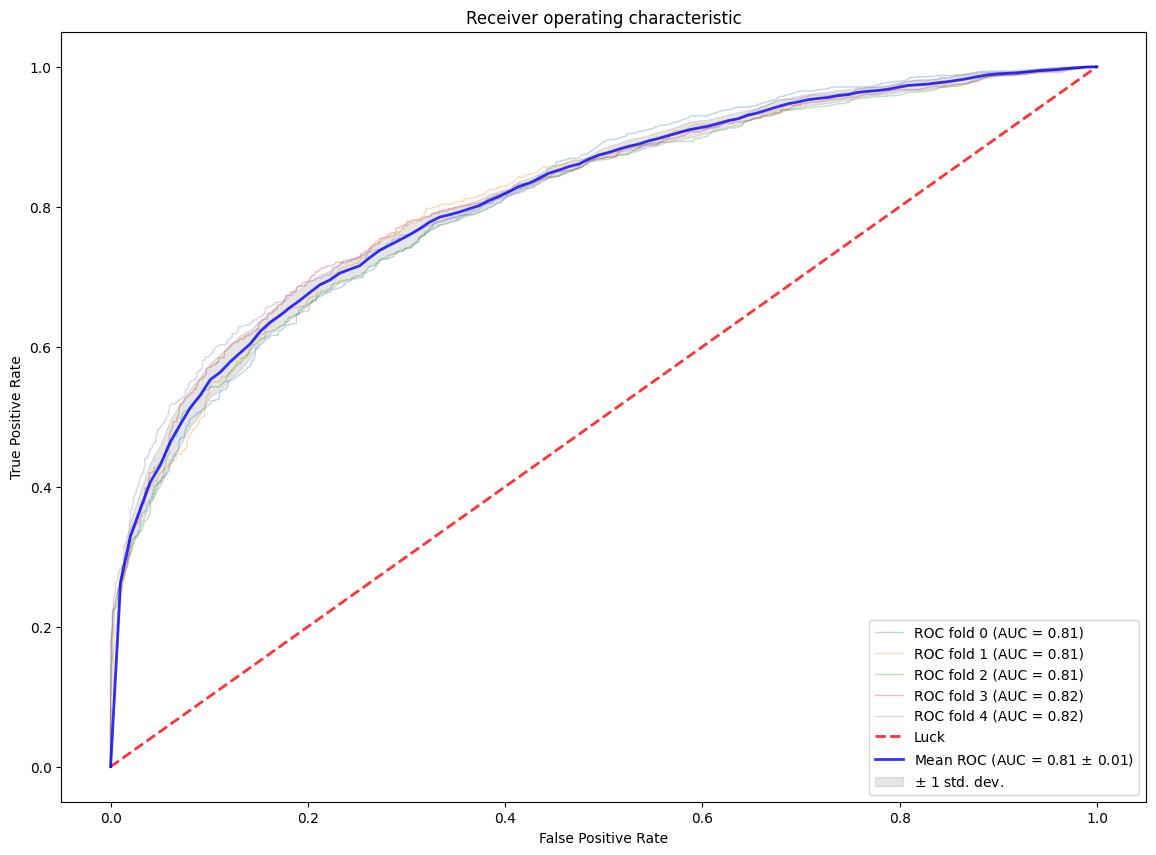

Accaracy list :  [0.7260932244113407, 0.739067755886593, 0.7299375300336377, 0.747236905333974, 0.7427884615384616]
equal opportunity for tpr :  [0.08938398721817853, 0.049275008417228094, 0.13470134091832597, 0.16883706844336765, 0.13877307921381776]
equal opportunity for fpr :  [0.12876924781211918, 0.14453713273291005, 0.06137731751264436, 0.10334538040960059, 0.1349488135392627]
odds difference list :  [0.10907661751514885, 0.09690607057506907, 0.09803932921548517, 0.13609122442648414, 0.13686094637654023]
The mean accuracy is  0.737 ± 0.008
The mean equal opportunity for tpr: (close to 0) 0.116 ± 0.042
The mean equal opportunity for fpr: (close to 0) 0.115 ± 0.030
The mean odds difference: (close to 0) 0.115 ± 0.018
The mean parity difference: (close to 0) 0.036 ± 0.025
The mean disperate impact: (close to 1) 0.470 ± 0.032


In [29]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [30]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(2601, 12) (2601, 12) (2601, 12) (2601, 12)


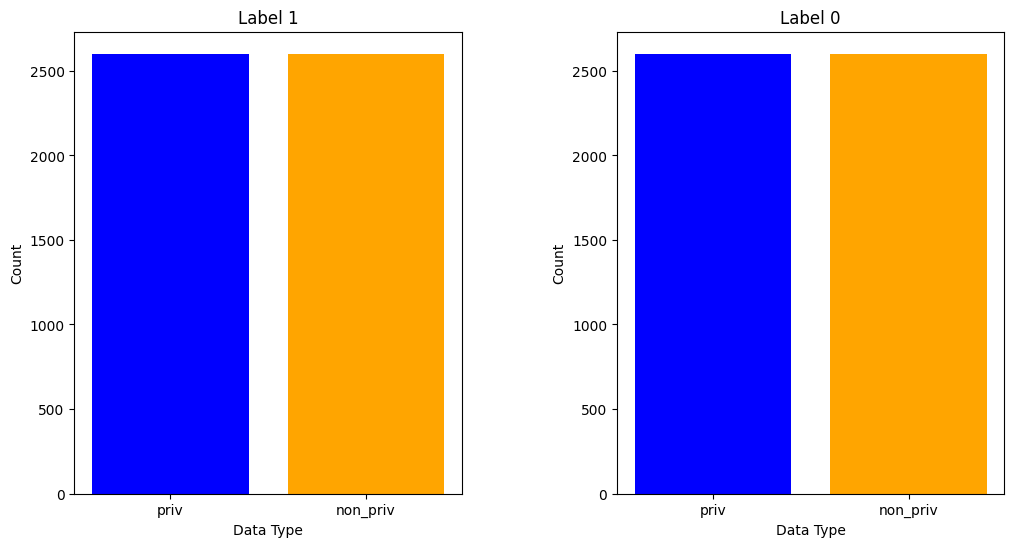

In [31]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[806 235]
 [335 705]] 
accuracy:  0.7260932244113407 precision:  0.75 recall:  0.6778846153846154 fpr:  0.22574447646493756 tpr:  0.6778846153846154 fn+fp 570
performance for 0 sub-group:
conf matrix:
  [[434  76]
 [145 379]] 
accuracy:  0.7862669245647969 precision:  0.832967032967033 recall:  0.7232824427480916 fpr:  0.14901960784313725 tpr:  0.7232824427480916 fn+fp 221
performance for 1 sub-group:
conf matrix:
  [[372 159]
 [190 326]] 
accuracy:  0.6666666666666666 precision:  0.6721649484536083 recall:  0.6317829457364341 fpr:  0.2994350282485876 tpr:  0.6317829457364341 fn+fp 349
bias metrics:
equal opportunity for tpr: (close to 0) 0.0914994970116575
equal opportunity for fpr: (close to 0) 0.15041542040545033
avarage absolute odds difference: (close to 0) 0.12095745870855391
statistical parity difference: (close to 0)  0.03191489361702127
disparate_impact: (close to 1)  0.48404255319148937
perform

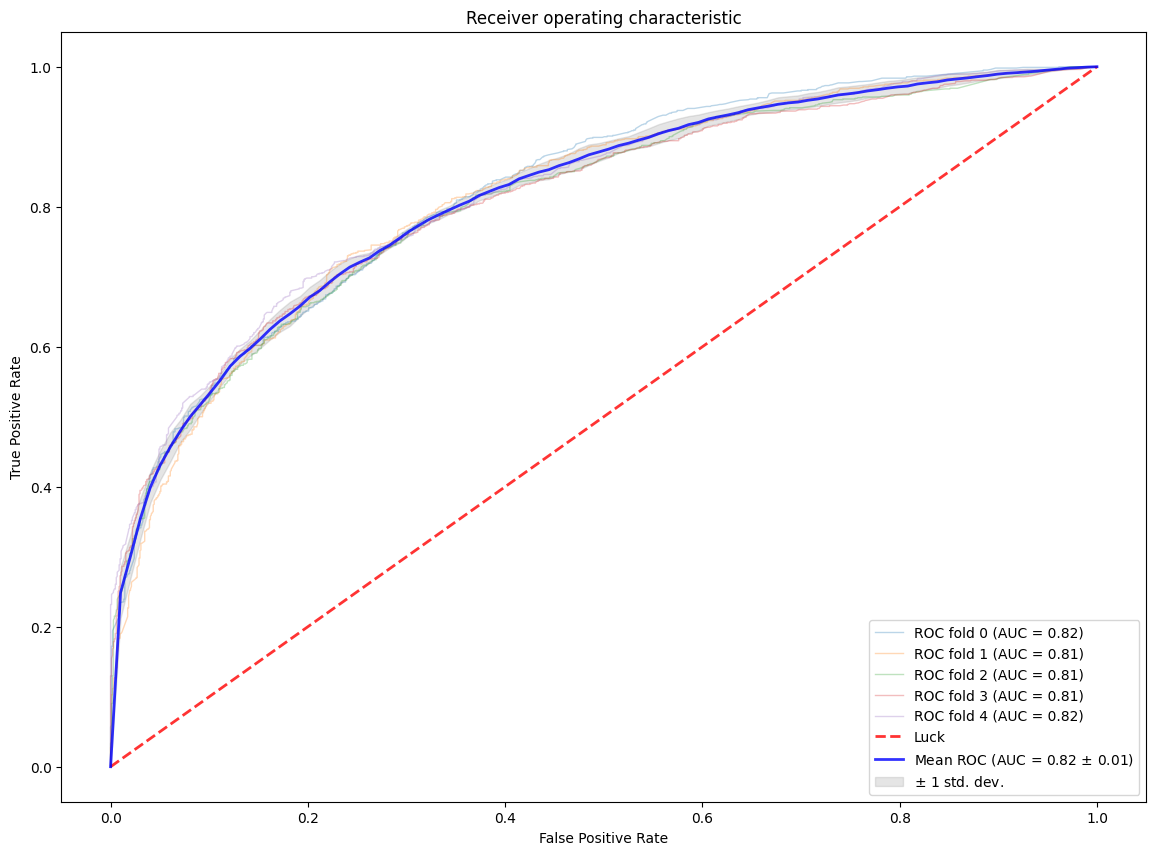

Accaracy list :  [0.7260932244113407, 0.74291206150889, 0.7260932244113407, 0.7333012974531475, 0.7480769230769231]
equal opportunity for tpr :  [0.0914994970116575, 0.07669852263771881, 0.12967751468360977, 0.12457712251259401, 0.11433158601504145]
equal opportunity for fpr :  [0.15041542040545033, 0.13301712682710762, 0.08888222910399995, 0.14082105458252248, 0.16228770933191317]
odds difference list :  [0.12095745870855391, 0.10485782473241322, 0.10927987189380486, 0.13269908854755824, 0.1383096476734773]
The mean accuracy is  0.735 ± 0.009
The mean equal opportunity for tpr: (close to 0) 0.107 ± 0.020
The mean equal opportunity for fpr: (close to 0) 0.135 ± 0.025
The mean odds difference: (close to 0) 0.121 ± 0.013
The mean parity difference: (close to 0) 0.023 ± 0.014
The mean disperate impact: (close to 1) 0.477 ± 0.021


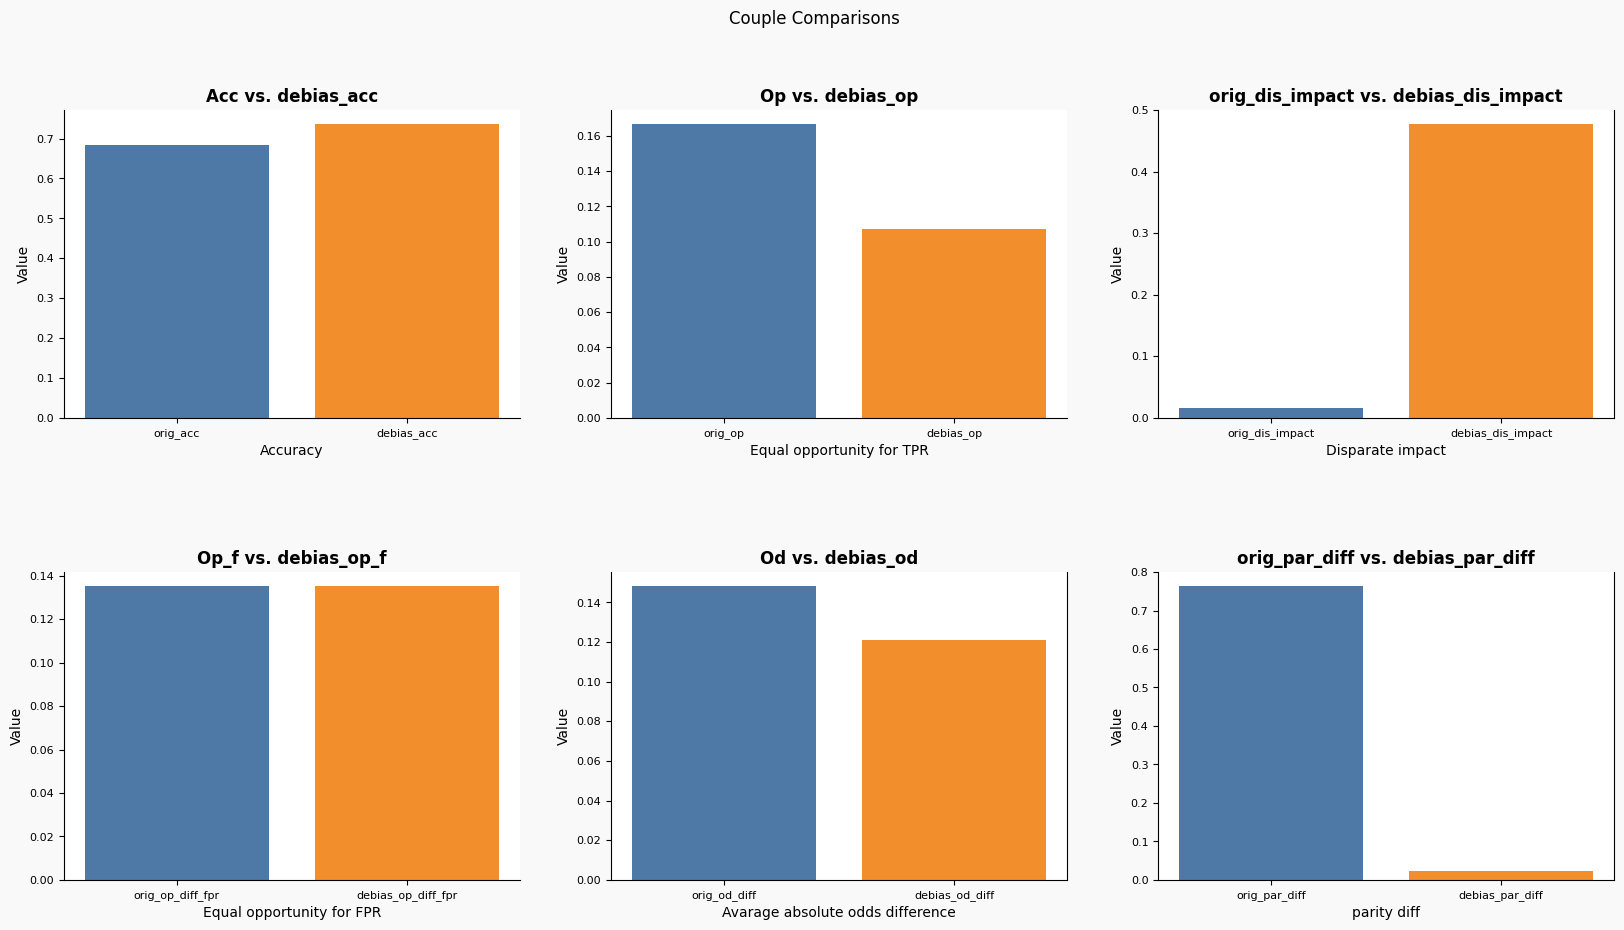

In [37]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [33]:
# Record the end time
end_time = time.time()

In [34]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 3.2707 minutes
